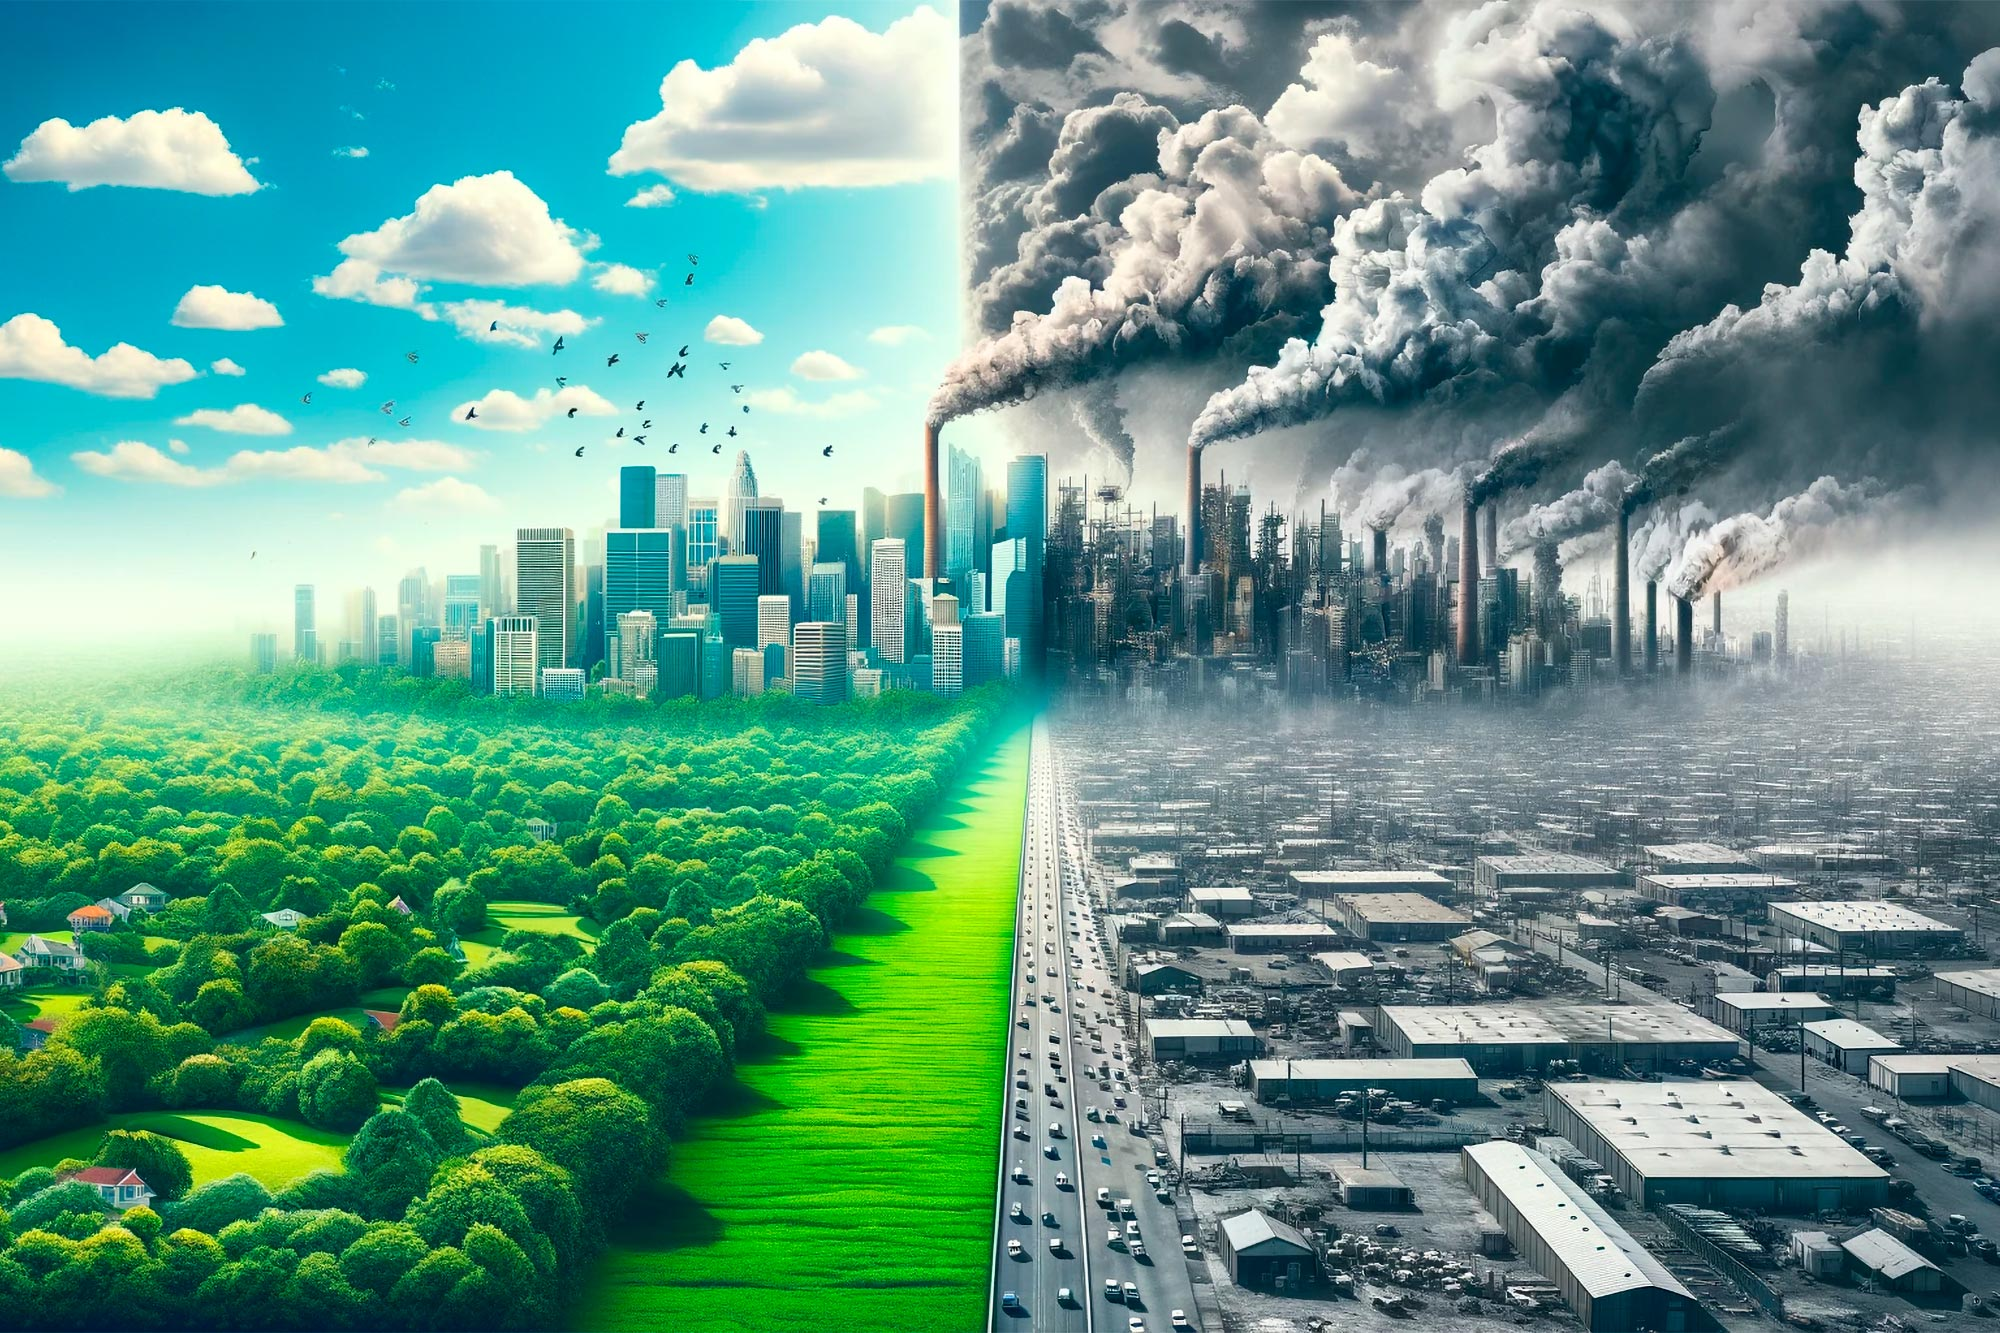

# Data Science Final

### By Matthew Thomas

## Loading and Cleaning

In [62]:
# Loading Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
import bar_chart_race as bcr
%matplotlib inline
import pandas as pd
from pandas_profiling import ProfileReport
import datetime as dt

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.metrics import mean_squared_error, r2_score

In [63]:
# Loading Dataset
df = pd.read_csv("C:/Users/prath/Downloads/US_AQI.csv")

Kaggle Link: https://www.kaggle.com/datasets/calebreigada/us-air-quality-1980present

Since the original dataset has over 5 million rows and I do not have access to a supercomputer, I have elected to filter the dataset to make the data more managable for the machine learning models.

In [64]:
print(df.shape)
df = df[::25]
print(df.shape)

(5617325, 15)
(224693, 15)


In [65]:
df.head()

,Unnamed: 0,CBSA Code,Date,AQI,Category,Defining Parameter,Number of Sites Reporting,city_ascii,state_id,state_name,lat,lng,population,density,timezone
0,0,10140,2022-01-01,21,Good,PM2.5,2,Aberdeen,WA,Washington,46.9757,-123.8094,16571.0,588.0,America/Los_Angeles
25,25,10140,2022-01-26,28,Good,PM2.5,2,Aberdeen,WA,Washington,46.9757,-123.8094,16571.0,588.0,America/Los_Angeles
50,50,10420,2022-01-20,15,Good,PM2.5,3,Akron,OH,Ohio,41.0798,-81.5219,570375.0,1230.0,America/New_York
75,75,10420,2022-02-14,35,Good,PM2.5,1,Akron,OH,Ohio,41.0798,-81.5219,570375.0,1230.0,America/New_York
100,100,10420,2022-03-11,38,Good,PM2.5,3,Akron,OH,Ohio,41.0798,-81.5219,570375.0,1230.0,America/New_York


In [66]:
# Removing unnecessary columns to reduce noise
df.drop(["Unnamed: 0", "CBSA Code", "Category",'city_ascii', "Number of Sites Reporting", "state_id", "timezone"], axis = 1, inplace = True)

# Changing the date column to the number of days since the beginning of 2022. This is so the machine learning models can understand the date.
df['Date'] = pd.to_datetime(df['Date'])
reference_date = pd.to_datetime("2022-01-01")
df['Date'] = (df['Date'] - reference_date).dt.days
print(df.dtypes)

Date                    int64
AQI                     int64
Defining Parameter     object
state_name             object
lat                   float64
lng                   float64
population            float64
density               float64
dtype: object


In [82]:
# Forming a Pandas Profiling Report to get a better grasp of the data before we start machine learning.
profile = ProfileReport(df)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Pre-Processing

In [67]:
# Splitting the AQI from the rest of the dataset. The AQI column will serve as the target.
df = df[['Date', 'Defining Parameter', 'state_name', 'lat',
       'lng', 'population', 'density', "AQI"]]
X = df.iloc[:, 0:7].values
y = df.iloc[:, 7].values
print(pd.DataFrame(X[:10]))
print(pd.DataFrame(y[:10]))

    0      1           2        3         4         5       6
0   0  PM2.5  Washington  46.9757 -123.8094   16571.0   588.0
1  25  PM2.5  Washington  46.9757 -123.8094   16571.0   588.0
2  19  PM2.5        Ohio  41.0798  -81.5219  570375.0  1230.0
3  44  PM2.5        Ohio  41.0798  -81.5219  570375.0  1230.0
4  69  PM2.5        Ohio  41.0798  -81.5219  570375.0  1230.0
5   4  PM2.5     Georgia  31.5776  -84.1762   89323.0   509.0
6  29  PM2.5     Georgia  31.5776  -84.1762   89323.0   509.0
7  54  PM2.5     Georgia  31.5776  -84.1762   89323.0   509.0
8  79  PM2.5     Georgia  31.5776  -84.1762   89323.0   509.0
9  16  PM2.5      Oregon  44.6272 -123.0965   66405.0  1190.0
    0
0  21
1  28
2  15
3  35
4  38
5  60
6  55
7  71
8  61
9  33


In [69]:
df.head()
# The only non-numerical data is the defining parameter and the state name

,Date,Defining Parameter,state_name,lat,lng,population,density,AQI
0,0,PM2.5,Washington,46.9757,-123.8094,16571.0,588.0,21
25,25,PM2.5,Washington,46.9757,-123.8094,16571.0,588.0,28
50,19,PM2.5,Ohio,41.0798,-81.5219,570375.0,1230.0,15
75,44,PM2.5,Ohio,41.0798,-81.5219,570375.0,1230.0,35
100,69,PM2.5,Ohio,41.0798,-81.5219,570375.0,1230.0,38


In [ ]:
# Encoding the parameter and the state columns so the machine learning models can interpret it

ct = ColumnTransformer([("Defining Parameter", OneHotEncoder(), [1])], remainder = 'passthrough', sparse_threshold=0)
X = ct.fit_transform(X)

ct = ColumnTransformer([("state_name", OneHotEncoder(), [6])], remainder = 'passthrough', sparse_threshold=0)
X = ct.fit_transform(X)

print(pd.DataFrame(X[:10]))

    0    1    2    3    4    5    6    7    8    9   ...   52   53   54   55  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
6  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
7  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
8  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
9  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   

    56  57       58        59        60      61  
0  1.0   0  46.9757 -123.8094   16571.0   588.0  
1  1.0  25  46.9757

In [71]:
# Final pre-processing before we start machine learning
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train = X_train.reshape((-1, 62))
X_train = np.asarray(X_train, dtype=np.float32)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Machine Learning Model Comparsion

In [73]:
# K Nearest Neighbor
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)

y_pred = knn_model.predict(X_test)

knn_mse = mean_squared_error(y_test, y_pred)
knn_r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {knn_mse}")
print(f"R^2 Score: {knn_r2}")
# Mean Squared Error and the R Score will be the main form of determing how well the model peforms.

Mean Squared Error: 669.7641362736155
R^2 Score: 0.21639597506843533


In [74]:
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

rf_mse = mean_squared_error(y_test, y_pred)
rf_r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {rf_mse}")
print(f"R^2 Score: {rf_r2}")

Mean Squared Error: 548.4188009056721
R^2 Score: 0.3583663912958961


In [75]:
# Light Gradient-Boosting Machine
# I went looking for a ML model that was good at taking in large datasets and came across LightGBM. I believe its based off of decision tree algorithms.
lgbm_model = LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
lgbm_model.fit(X_train, y_train)

y_pred = lgbm_model.predict(X_test)

lgbm_mse = mean_squared_error(y_test, y_pred)
lgbm_r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {lgbm_mse}")
print(f"R^2 Score: {lgbm_r2}")
# This model was way faster than others

Mean Squared Error: 565.2559035717729
R^2 Score: 0.3386674843183617


In [ ]:
# Artifical Neural Network
classifier = Sequential()
model = Sequential()
model.add(Dense(64, input_shape=(62,), activation='relu')) 
model.add(Dense(1, activation='linear')) 
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

C:\Users\prath\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# This combo of batch size and epoch lead to the best R score. A lower batch size and higher epoch might have led to a better scoring, but the code takes 15+ minutes to run,
# so at some point I'm not sure if it's still running or if I broke it.
model.fit(X_train, y_train, batch_size = 30, epochs = 10)
y_pred = model.predict(X_test)

Epoch 1/10
5992/5992 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 1655.6877 - mse: 1655.6877
Epoch 2/10
5992/5992 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 886.9681 - mse: 886.9681
Epoch 3/10
5992/5992 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 783.6710 - mse: 783.6710
Epoch 4/10
5992/5992 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 896.2302 - mse: 896.2302
Epoch 5/10
5992/5992 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 775.6364 - mse: 775.6364
Epoch 6/10
5992/5992 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 971.4050 - mse: 971.4050
Epoch 7/10
5992/5992 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 1064.2070 - mse: 1064.2070
Epoch 8/10
5992/5992 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 850.7674 - mse: 850.7674
Epoch 9/10
5992/5992 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 915.8696 - mse: 915.8696
Epoch 10/10
5992/5992 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 863.5195 - mse: 863.5195
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 1s 813us/step


In [78]:
loss, mse = model.evaluate(X_test, y_test, verbose=0)

ann_mse = mean_squared_error(y_test, y_pred)
ann_r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {ann_mse}")
print(f"R² Score: {ann_r2}")

Mean Squared Error (MSE): 626.0269829354274
R² Score: 0.26756709814071655


## Visualization of Model Peformance

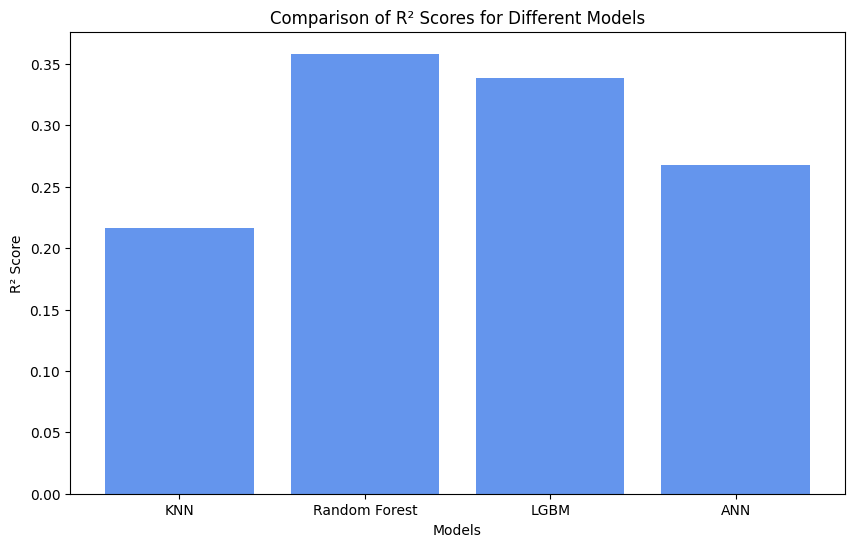

In [79]:
models = ['KNN', 'Random Forest', 'LGBM', 'ANN']
r2_scores = [knn_r2, rf_r2, lgbm_r2, ann_r2]

plt.figure(figsize=(10, 6))
plt.bar(models, r2_scores, color='cornflowerblue')

plt.xlabel('Models')
plt.ylabel('R² Score')
plt.title('Comparison of R² Scores for Different Models')

plt.show()
# I tried to make these graphs animated, and better in general, but I couldn't figure it out in time

A higher R-Score is better, so it looks like Random Forest comes out on top, with LGBM close behind, followed by ANN and then KNN. I didn't expect LGBM to do so well, I was expecting it to be fast but dumb. What a pleasant suprise!

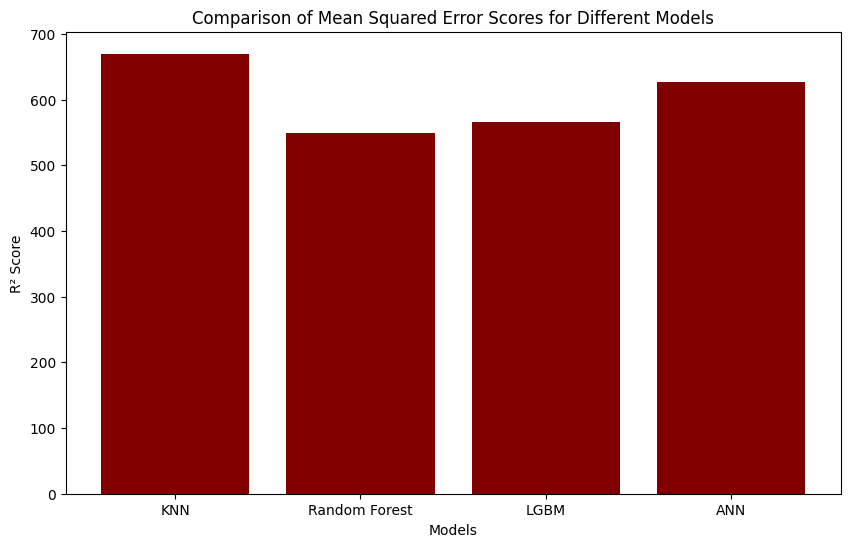

In [80]:
models = ['KNN', 'Random Forest', 'LGBM', 'ANN']
r2_scores = [knn_mse, rf_mse, lgbm_mse, ann_mse]

plt.figure(figsize=(10, 6))
plt.bar(models, r2_scores, color='maroon')

plt.xlabel('Models')
plt.ylabel('R² Score')
plt.title('Comparison of Mean Squared Error Scores for Different Models')

plt.show()

With Mean Squared Error, lower is better. The same pattern appears, with Random Forest in 1st, LGBM in 2nd, ANN in 3rd, and KNN in 4th

## NJ Simulation

Let's see how our best model predicts the AQI for Ocean County, NJ on January 24, 2025.

In [81]:
nj = np.array([
    1119, # days since 1/1/22
    1, # assuming the particulate matter is PM2.5, which it has been through this week
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
    1, # the encoded column for NJ
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
    39.9653, 74.3118, # The coordinates for Ocean County
    659197, 700 # The population and density for Ocean County
])
nj = nj.reshape(1, 62)
nj_prediction = rf_model.predict(nj)
print(nj_prediction)

[79.51]


Our best model predicts an AQI of about 80. An AQI of 51-100 is considered moderate and presents no risk for ordinary people, though a slight risk may be present for people sensitive to air pollution. Is the model's prediction correct? Only time will tell!